In [1]:
import numpy as np
import pandas as pd

import os
import librosa

import scipy
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas

tqdm.pandas()

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC

In [2]:
# Load data
data_folder = os.getcwd() + '\\data'

train_path = os.getcwd() + '\\data\\training_set'
vali_path = os.getcwd() + '\\data\\validation_set'
test_path = os.getcwd() + '\\data\\testing_set'

audio_train_folder = os.listdir(os.getcwd() + '\\data\\training_set')
audio_vali_folder = os.listdir(os.getcwd() + '\\data\\validation_set')
audio_test_folder = os.listdir(os.getcwd() + '\\data\\testing_set')

train = pd.read_csv(os.getcwd() + '\\data\\training_final.csv')
test = pd.read_csv(os.getcwd() + '\\data\\testing.csv')
#submission = pd.read_csv('../input/sample_submission.csv')

In [3]:
SAMPLE_RATE = 44100 #Commonly used standard sampling rates for audio processing include 8 kHz, 16 kHz, 44.1 kHz, and 48 kHz.

def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

# Generate mfcc features with mean and standard deviation
def get_mfcc_and_spec(name, path):
    data, _ = librosa.core.load(path + '\\' + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        ft1 = librosa.feature.mfcc(y=data, sr = SAMPLE_RATE, n_mfcc=30)
        ft2 = librosa.feature.zero_crossing_rate(y=data)[0]
        ft3 = librosa.feature.spectral_rolloff(y=data)[0]
        ft4 = librosa.feature.spectral_centroid(y=data)[0]
        ft5 = librosa.feature.spectral_contrast(y=data)[0]
        ft6 = librosa.feature.spectral_bandwidth(y=data)[0]
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
        ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
        ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
        ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
        ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
        ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
        #stacked = np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))
        return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
    except:
        print('bad file: ' + name) #v79 got removed
        return pd.Series([0]*210)
    
# Generate mfcc features 
def get_mfcc(name, path, n_mfcc = 13):
    data, _ = librosa.core.load(path + '\\' + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        mfcc = librosa.feature.mfcc(y=data, sr = SAMPLE_RATE, n_mfcc = 30) #Start increasing if needed
        delta_mfccs = librosa.feature.delta(mfcc)
        delta2_mfccs = librosa.feature.delta(mfcc, order = 2)
        comprehensive_mfccs = np.concatenate((mfcc, delta_mfccs, delta2_mfccs))
        return comprehensive_mfccs
        #return mfcc

    except:
        print('bad file: ' + name) #v79 got removed
        return np.zeros(((n_mfcc*3), 1))

def pad_mfcc(mfcc, max_mfcc_len):
    pad_width = max_mfcc_len - mfcc.shape[1]
    padded_mfcc = np.pad(mfcc, pad_width = ((0,0),(0, pad_width)), mode = 'constant')
    return padded_mfcc

# Convert predicted index to classes
def i2c(preds, i2c, k=3):
    ans = []
    ids = []
    for p in preds:
        idx = np.argsort(p)[::-1]
        ids.append([i for i in idx[:k]])
        ans.append(' '.join([str(i2c[i]) for i in idx[:k]]))

    return ans, ids

# Convert classes to indexes
def c2i(df, targetcol, col_data):
    c2i = {}
    i2c = {}
    for i, c in enumerate(col_data):
        c2i[c] = i
        i2c[i] = c
    y = np.array([c2i[x] for x in df[targetcol].values])
    return y

In [4]:
#Initialise relevant data frames
train_data = pd.DataFrame()
train_data['fname'] = train['fname']
test_data = pd.DataFrame()
test_data['fname'] = test['fname']
train_data['label'] = train['label']
test_data['label'] = test['label']

In [5]:
train_data = train_data['fname'].progress_apply(get_mfcc, path=train_path)
print('done generating train mfcc')
test_data = test_data['fname'].progress_apply(get_mfcc, path=test_path)
print('done generating test mfcc')

#get mfcc features
#train_data['mfcc'] = train_data['fname'].progress_apply(get_mfcc, path=train_path)
#print('done generating train mfcc')
#test_data['mfcc'] = test_data['fname'].progress_apply(get_mfcc, path=test_path)
#print('done generating test mfcc')

100%|██████████| 532/532 [02:08<00:00,  4.13it/s]


done generating train mfcc


100%|██████████| 75/75 [00:15<00:00,  4.69it/s]

done generating test mfcc


In [14]:
# train_features = train_data
# train_labels = train['label']

# test_features = test_data
# test_labels = test['label']

In [21]:
# clf1 = SVC(kernel = 'linear')
# clf1.fit(train_features, train_labels)
# clf1_pred = clf1.predict(test_features)

# cm1 = confusion_matrix(test_labels, clf1_pred)
# accuracy1 = metrics.accuracy_score(test_labels, clf1_pred)
# precision1 = metrics.precision_score(test_labels, clf1_pred)
# recall1 = metrics.recall_score(test_labels, clf1_pred)
# f1_score1 = metrics.f1_score(test_labels, clf1_pred)

# print("SVM linear kernel")
# print("Accuracy:",  round(accuracy1, 2))
# print("Precision:", round(precision1, 2))
# print("Recall:", round(recall1, 2))
# print("F1 Score:", round(f1_score1, 2))
# print(cm1)

SVM linear kernel
Accuracy: 0.64
Precision: 0.26
Recall: 0.28
F1 Score: 0.27
[[43 14]
 [13  5]]


In [38]:
# # Fit an SVM model
# #X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2, random_state = 42, shuffle = True)

# clf2 = SVC(kernel = 'rbf', probability=True, gamma="scale")
# print(clf2.get_params())
# clf2_pred = clf2.fit(train_features, train_labels)
# clf2_pred = clf2.predict(test_features)

# cm2 = confusion_matrix(test_labels, clf2_pred)
# accuracy2 = metrics.accuracy_score(test_labels, clf2_pred)
# precision2 = metrics.precision_score(test_labels, clf2_pred)
# recall2 = metrics.recall_score(test_labels, clf2_pred)
# f1_score2 = metrics.f1_score(test_labels, clf2_pred)

# print("SVM rbf kernel")
# print("Accuracy:",  round(accuracy2,2))
# print("Precision:", round(precision2,2))
# print("Recall:", round(recall2,2))
# print("F1 Score:", round(f1_score2,2))
# print(cm2)

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
SVM rbf kernel
Accuracy: 0.49
Precision: 0.21
Recall: 0.39
F1 Score: 0.27
[[30 27]
 [11  7]]


In [6]:
#Finding max MFCC length in train and test data
max_len = -1 
for index, row in train_data.iterrows():
    mfcc_data = row['mfcc']
    if len(np.shape(mfcc_data)) == 1:
        raise Exception("Bad file: " + row['fname'])
    else: 
        if np.shape(mfcc_data)[1] > max_len:
            max_len = np.shape(mfcc_data)[1]

for index, row in test_dat  a.iterrows():
    mfcc_data = row['mfcc']
    if len(np.shape(mfcc_data)) == 1:
        raise Exception("Bad file: " + row['fname'])
    else: 
        if np.shape(mfcc_data)[1] > max_len:
            max_len = np.shape(mfcc_data)[1]

#Pad test and train data to same length
train_data['mfcc'] = train_data['mfcc'].progress_apply(pad_mfcc, max_mfcc_len=max_len)
test_data['mfcc'] = test_data['mfcc'].progress_apply(pad_mfcc, max_mfcc_len=max_len)

#Flatten data
train_data['mfcc'] = train_data['mfcc'].progress_apply(lambda x: x.flatten())
test_data['mfcc'] = test_data['mfcc'].progress_apply(lambda x: x.flatten())

print(train_data['mfcc'].shape)	

KeyError: 'mfcc'

In [ ]:
#Construct features set for train - Extract mfcc and labels
train_features = train_data.mfcc.tolist()
train_labels = train_data.label.tolist()
#print(np.shape(train_features))
#print(np.shape(train_labels))
#train_drop = train_data.drop(['label', 'fname'], axis=1)
#feature_names = list(train_drop.columns)
#train_drop = train_drop.values #Get MFCC values in an array

#Construct features set for test - Extract mfcc and labels
test_features = test_data.mfcc.tolist()
test_labels = test_data.label.tolist()
#test_drop = test_data.drop(['label', 'fname'], axis=1)
#test_drop = test_drop.values #Get MFCC values in an array

#Finding no of classes
unique_labels = np.sort(np.unique(train_data.label.values))
num_class = len(unique_labels)

In [ ]:
# Try going without scaling first
# Apply scaling for PCA
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(train_drop)
#X_test_scaled = scaler.transform(test_drop)

In [ ]:
# Apply PCA for dimension reduction
#pca = PCA(n_components=65).fit(X_train_scaled)
#X_pca = pca.transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)

#print(sum(pca.explained_variance_ratio_)) 

In [ ]:
clf1 = SVC(kernel = 'linear')
clf1.fit(train_features, train_labels)
clf1_pred = clf1.predict(test_features)

cm1 = confusion_matrix(test_labels, clf1_pred)
accuracy1 = metrics.accuracy_score(test_labels, clf1_pred)
precision1 = metrics.precision_score(test_labels, clf1_pred)
recall1 = metrics.recall_score(test_labels, clf1_pred)
f1_score1 = metrics.f1_score(test_labels, clf1_pred)

print("SVM linear kernel")
print("Accuracy:",  round(accuracy1, 2))
print("Precision:", round(precision1, 2))
print("Recall:", round(recall1, 2))
print("F1 Score:", round(f1_score1, 2))
print(cm1)

SVM linear kernel
Accuracy: 0.69
Precision: 0.14
Recall: 0.06
F1 Score: 0.08
[[51  6]
 [17  1]]


In [28]:
# Fit an SVM model
#X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2, random_state = 42, shuffle = True)

clf2 = SVC(kernel = 'rbf', probability=True)
clf2_pred = clf2.fit(train_features, train_labels)
clf2_pred = clf2.predict(test_features)

cm2 = confusion_matrix(test_labels, clf2_pred)
accuracy2 = metrics.accuracy_score(test_labels, clf2_pred)
precision2 = metrics.precision_score(test_labels, clf2_pred)
recall2 = metrics.recall_score(test_labels, clf2_pred)
f1_score2 = metrics.f1_score(test_labels, clf2_pred)

print("SVM rbf kernel")
print("Accuracy:",  round(accuracy2,2))
print("Precision:", round(precision2,2))
print("Recall:", round(recall2,2))
print("F1 Score:", round(f1_score2,2))
print(cm2)

SVM rbf kernel
Accuracy: 0.49
Precision: 0.21
Recall: 0.39
F1 Score: 0.27
[[30 27]
 [11  7]]


In [ ]:
# Define the paramter grid for C from 0.001 to 10, gamma from 0.001 to 10
C_grid = [0.001, 0.01, 0.1, 1, 10]
gamma_grid = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': C_grid, 'gamma' : gamma_grid}

grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv = 3, scoring = "accuracy")
grid.fit(train_features, train_labels)
grid_pred = grid.predict(test_features)

# Find the best model
print(grid.best_score_)

print(grid.best_params_)

print(grid.best_estimator_)

In [ ]:
# Optimal model
#clf3 = SVC(kernel = 'rbf', C = 4, gamma = 0.01, probability=True)

#clf3.fit(X_train, y_train)

#print(accuracy_score(clf.predict(X_val), y_val))

0.9104477611940298


In [ ]:
# Fit the entire training sets
# clf.fit(X_pca, y)
# str_preds, _ = convert_to_labels(clf.predict_proba(X_test_pca), i2c, k=3)

# # Write to outputs
# subm = pd.DataFrame()
# subm['fname'] = test['fname']
# subm['label'] = str_preds
# subm['correct_label'] = test['label']

# subm.to_csv('submission.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'submission.csv'

## Debugging

WAV file:  Fs = 44100, x.shape = (803943,), x.dtype = float32

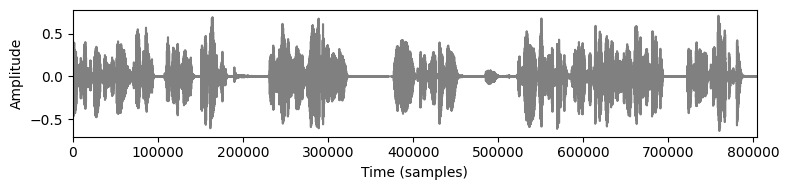

bad file


0      0
1      0
2      0
3      0
4      0
      ..
205    0
206    0
207    0
208    0
209    0
Length: 210, dtype: int64

In [ ]:
#ISOLATING ERROR
def print_plot_play(x, Fs, text=''):
    """1. Prints information about an audio singal, 2. plots the waveform, and 3. Creates player
    
    Notebook: C1/B_PythonAudio.ipynb
    
    Args: 
        x: Input signal
        Fs: Sampling rate of x    
        text: Text to print
    """
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

# Generate mfcc features with mean and standard deviation
def get_mfcc2(name, path):
    SAMPLE_RATE = 44100 #Commonly used standard sampling rates for audio processing include 8 kHz, 16 kHz, 44.1 kHz, and 48 kHz.
    x, Fs = librosa.core.load(path + '\\' + name, sr = SAMPLE_RATE)
    print_plot_play(x=x, Fs=Fs, text='WAV file: ')
    assert Fs == SAMPLE_RATE
    ft1 = librosa.feature.mfcc(y=x, sr = SAMPLE_RATE, n_mfcc=30)
    try:
        
        ft2 = librosa.feature.zero_crossing_rate(data)[0]
        ft3 = librosa.feature.spectral_rolloff(data)[0]
        ft4 = librosa.feature.spectral_centroid(data)[0]
        ft5 = librosa.feature.spectral_contrast(data)[0]
        ft6 = librosa.feature.spectral_bandwidth(data)[0]
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
        ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
        ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
        ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
        ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
        ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
        return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
    except:
        print('bad file')
        return pd.Series([0]*210)

get_mfcc2(name='positive_out.wav', path='C:\\Users\\benny\\Desktop\\Y4S1\\Deep_Speech_Technology\\Project\\data\\testing_set\\t_18')

In [ ]:
#Construct features set
X = train_data.drop(['label', 'fname'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(train_data.label.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in train_data.label.values])

In [ ]:
X_test = test_data.drop(['label', 'fname'], axis=1)
X_test = X_test.values

In [ ]:
print(X.shape)
print(X_test.shape)

(335, 210)
(75, 210)
